**MITx 6.419x  Data Analysis: Statistical Modeling and Computation in Applications**  
Written report -- Homework 2  
Student Name (Leonel_41)  
06/10/2025 
---

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.linear_model import LogisticRegression

In [3]:
# Data Preparation

X = np.load('../../data/p2_unsupervised/X.npy')
print(X.shape)
X_log = np.log2(X+1)
print(X_log[:, 0].max())

(2169, 45768)
5.972169178513185


### 5. Problem 2: Larger unlabeled subset

#### Part 1: Visualization

>A scientist tells you that cells in the brain are either excitatory neurons, inhibitory neurons, or non-neuronal cells. Cells from each of these three groups serve different functions within the brain. Within each of these three types, there are numerous distinct sub-types that a cell can be, and sub-types of the same larger class can serve similar functions. Your goal is to produce visualizations which show how the scientist's knowledge reflects in the data.


  
> **1.** Provide at least one visualization which clearly shows the existence of the three main brain cell types described by the scientist, and explain how it shows this. Your visualization should support the idea that cells from a different group (for example, excitatory vs inhibitory) can differ greatly.  


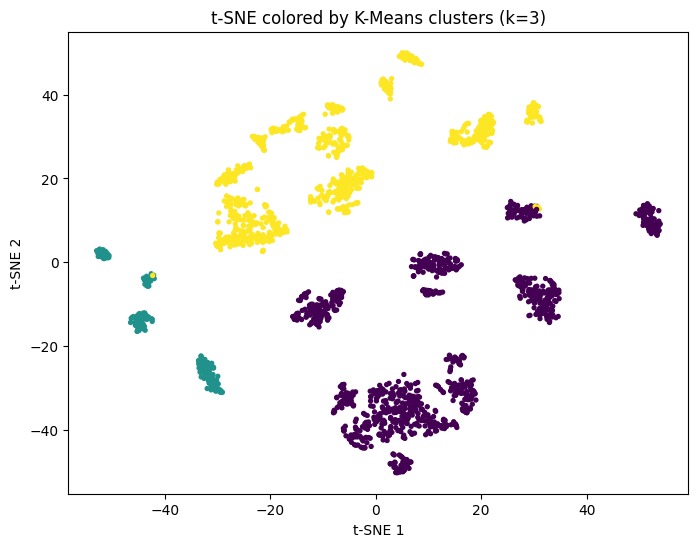

In [42]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_log)

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, cmap="viridis", s=8)
plt.title("t-SNE colored by K-Means clusters (k=3)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

Using PCA followed by t-SNE, we visualized the cells in two dimensions. \
Applying K-Means with k=3 reveals three clearly separated clusters, indicating that cells fall into three main groups.

  
> **2.** Provide at least one visualization which supports the claim that within each of the three types, there are numerous possible sub-types for a cell. In your visualization, highlight which of the three main types these sub-types belong to. Again, explain how your visualization supports the claim.


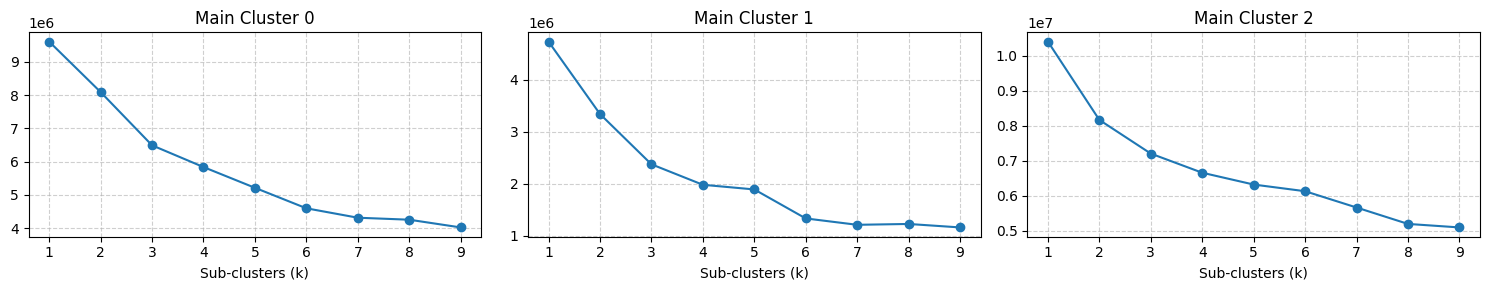

In [43]:
unique_clusters = np.unique(clusters)
fig, axes = plt.subplots(1, len(unique_clusters), figsize=(15, 3))

for i, main_cluster in enumerate(unique_clusters):
    mask = clusters == main_cluster
    X_group = X_pca[mask]

    inertias = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_group)
        inertias.append(kmeans.inertia_)

    axes[i].plot(K, inertias, 'o-')
    axes[i].set_title(f"Main Cluster {main_cluster}")
    axes[i].set_xlabel("Sub-clusters (k)")
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

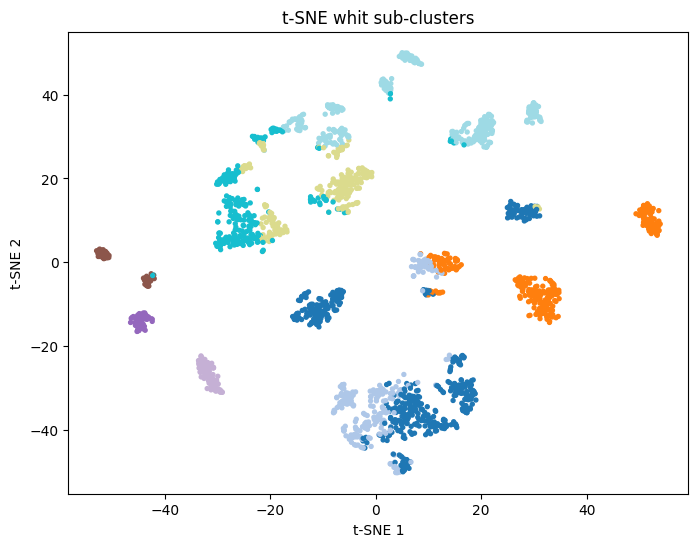

In [49]:
sub_clusters = np.zeros_like(clusters)

n_subclusters = {0:4, 1:3, 2:4}

for main_cluster in np.unique(clusters):
    mask = clusters == main_cluster
    kmeans_sub = KMeans(n_clusters=n_subclusters[main_cluster], random_state=42)
    sub_clusters[mask] = (
        kmeans_sub.fit_predict(X_pca[mask]) + main_cluster * 10
    )

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=sub_clusters, cmap='tab20', s=8)
plt.title("t-SNE whit sub-clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

We used the elbow method to estimate the optimal number of sub-clusters within each main cluster.\
Then, we applied K-Means within each group to identify these sub-clusters.\
We observed clear differences among the subgroups within each main group.

  
#### Part 2: Unsupervised Feature Selection

> Now we attempt to find informative genes which can help us differentiate between cells, using only unlabeled data. A genomics researcher would use specialized, domain-specific tools to select these genes. We will instead take a general approach using logistic regression in conjunction with clustering. Briefly speaking, we will use the `p2_unsupervised` dataset to cluster the data. Treating those cluster labels as ground truth, we will fit a logistic regression model and use its coefficients to select features. Finally, to evaluate the quality of these features, we will fit another logistic regression model on the training set in `p2_evaluation`, and run it on the test set in the same folder.


  
>**1.** Using your clustering method(s) of choice, find a suitable clustering for the cells. Support your choice of clustering with appropriate visualizations and/or numerical findings. Be sure to briefly explain how you chose the number of clusters.


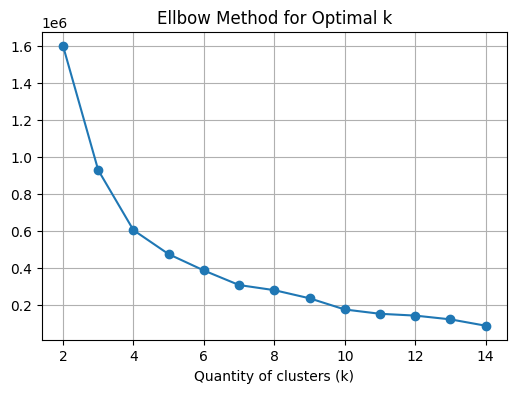

In [4]:
# PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_log)

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Ellbow method
inertias = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tsne)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, 'o-')
plt.xlabel("Quantity of clusters (k)")
plt.title("Ellbow Method for Optimal k")
plt.grid(True)
plt.show()

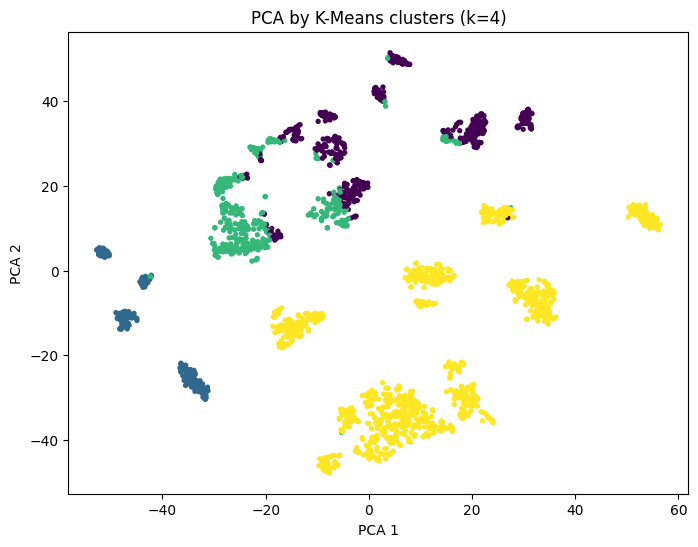

In [5]:
# K-Means with optimal k
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(X_pca)
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, cmap="viridis", s=8)
plt.title(f"PCA by K-Means clusters (k={k_opt})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

Using the elbow method, we observed that the optimal number of clusters is 4.\
We then projected the data to 2 dimensions using t-SNE to visualize the groups and get an idea of the identified cell subtypes.\
The visualization shows that the cells form well-separated groups, suggesting that these clusters may represent subcategories of cells within the main types.

  
>**2.** We will now treat your cluster assignments as labels for supervised learning. Fit a logistic regression model to the original data (not principal components), with your clustering as the target labels. Since the data is high-dimensional, make sure to regularize your model using your choice of $\ell _1$, $\ell _2$, or elastic net, and separate the data into training and validation or use cross-validation to select your model. Report your choice of regularization parameter and validation performance.


In [6]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_log, clusters, test_size=0.2, random_state=42)

# Standardize features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Logistic Regression with cross-validation
lr = LogisticRegressionCV(
    Cs=10,            
    cv=5,             
    penalty='l2',        
    multi_class='multinomial',
    max_iter=1000,
    random_state=42
)
lr.fit(X_train_scaled, y_train)

/home/leonel-unix/workspace/MITx-6.419x-data-analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1946: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Cs,10
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l2'
,scoring,None
,solver,'lbfgs'
,tol,0.0001
,max_iter,1000
,class_weight,None
,n_jobs,None


In [8]:
y_pred = lr.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
print("Validation accuracy:", accuracy)

Validation accuracy: 0.9815668202764977


Treated the clusters obtained from unsupervised clustering as pseudo-labels and trained a multinomial logistic regression on the original gene expression data.\
Due to the high dimensionality of the dataset, I applied L2 regularization to prevent overfitting and stabilize the model.\
The regularization strength C was internally optimized using 5-fold cross-validation across 10 candidate values.\
On the validation set, the model achieved a high accuracy of 0.982, indicating that the logistic regression is able to effectively predict cluster membership using the original features.\
This confirms that the clusters capture meaningful differences between cell subtypes and demonstrates that the coefficients of my model can be used for unsupervised feature selection, identifying genes that are most informative for distinguishing subtypes.

  
>**3.** Select the features with the top 100 corresponding coefficient values (since this is a multi-class model, you can rank the coefficients using the maximum absolute value over classes, or the sum of absolute values). Take the evaluation training data and use a subset of the genes, consisting of the features you selected. Train a logistic regression classifier on this training data, and evaluate its performance on the evaluation test data. Report your score. Compare with two baselines: random features (take a random selection of 100 genes), and high-variance features (take the 100 genes with highest variance). Compare the variances of the features you selected with the highest variance features by plotting a histogram of the variances of features selected by both methods.


In [11]:
# Feature importance - Top 100 genes
coef_abs = np.abs(lr.coef_)        
gene_importance = coef_abs.sum(axis=0)
top_genes_idx = np.argsort(gene_importance)[-100:]

In [13]:
X_eval_train = np.load("../../data/p2_evaluation/X_train.npy")
X_eval_test = np.load("../../data/p2_evaluation/X_test.npy")
y_eval_train = np.load("../../data/p2_evaluation/y_train.npy")
y_eval_test = np.load("../../data/p2_evaluation/y_test.npy")

In [ ]:
X_eval_train_log = np.log2(X_eval_train + 1)
X_eval_test_log = np.log2(X_eval_test + 1)

# Subset top 100 genes
X_train_top = X_eval_train_log[:, top_genes_idx]
X_test_top = X_eval_test_log[:, top_genes_idx]

In [23]:
lr_eval = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_eval.fit(X_train_top, y_eval_train)
y_pred_top = lr_eval.predict(X_test_top)
accuracy_top = accuracy_score(y_eval_test, y_pred_top)
accuracy_top

/home/leonel-unix/workspace/MITx-6.419x-data-analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.8898916967509025

In [21]:
# Random 100 genes
rand_idx = np.random.choice(X_eval_train.shape[1], 100, replace=False)
X_train_rand = X_eval_train_log[:, rand_idx]
X_test_rand = X_eval_test_log[:, rand_idx]

lr_rand = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_rand.fit(X_train_rand, y_eval_train)
accuracy_rand = accuracy_score(y_eval_test, lr_rand.predict(X_test_rand))
accuracy_rand

/home/leonel-unix/workspace/MITx-6.419x-data-analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/leonel-unix/workspace/MITx-6.419x-data-analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.4151624548736462

In [22]:
# High-variance 100 genes
variances = X_eval_train_log.var(axis=0)
highvar_idx = np.argsort(variances)[-100:]
X_train_var = X_eval_train_log[:, highvar_idx]
X_test_var = X_eval_test_log[:, highvar_idx]

lr_var = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_var.fit(X_train_var, y_eval_train)
accuracy_var = accuracy_score(y_eval_test, lr_var.predict(X_test_var))
accuracy_var

/home/leonel-unix/workspace/MITx-6.419x-data-analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.9323104693140795

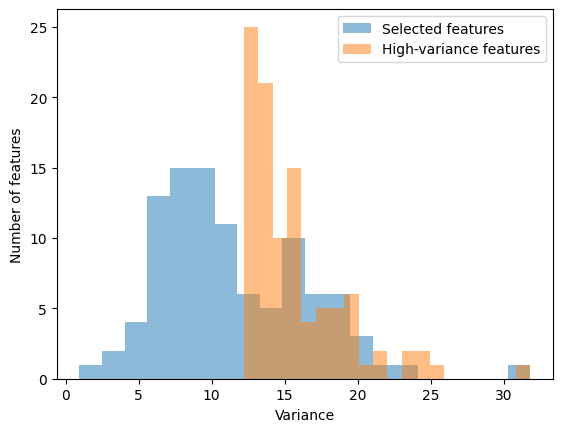

In [20]:
plt.hist(variances[top_genes_idx], bins=20, alpha=0.5, label="Selected features")
plt.hist(variances[highvar_idx], bins=20, alpha=0.5, label="High-variance features")
plt.xlabel("Variance")
plt.ylabel("Number of features")
plt.legend()
plt.show()

I selected the top 100 genes based on the sum of absolute coefficients from the logistic regression model trained on the clusters. Using these genes, I trained a logistic regression classifier on the evaluation training set (after log-transforming the data) and tested it on the evaluation set, which gave an accuracy of 0.889. To see how this compares, I also trained models using 100 random genes and the 100 highest-variance genes. The random genes gave a much lower accuracy of 0.415, while the high-variance genes reached 0.932.

Looking at the variances, the genes I selected have moderate variance, while the high-variance genes are obviously biased toward the largest values. This shows that the most informative genes for distinguishing cell subtypes aren’t necessarily the ones that vary the most. It highlights that using the logistic regression coefficients is a smarter way to pick useful genes rather than just picking the most variable ones.

  
### 6. Problem 3: Influence of Hyper-parameters

> The hyper-parameter choices used in data analysis techniques can have a large impact on the inferences made. As you may have encountered, finding the best choice of parameter such as perplexity in T-SNE or the number of clusters can be an ambiguous problem. We will now investigate the sensitivity of your results to changes in these hyper-parameters, with the goal of understanding how your conclusions may vary depending on these choices.


  
>**1.** When we created the T-SNE plot in Problem 1, we ran T-SNE on the top 50 PC's of the data. But we could have easily chosen a different number of PC's to represent the data. Run T-SNE using 10, 50, 100, 250, and 500 PC's, and plot the resulting visualization for each. What do you observe as you increase the number of PC's used?


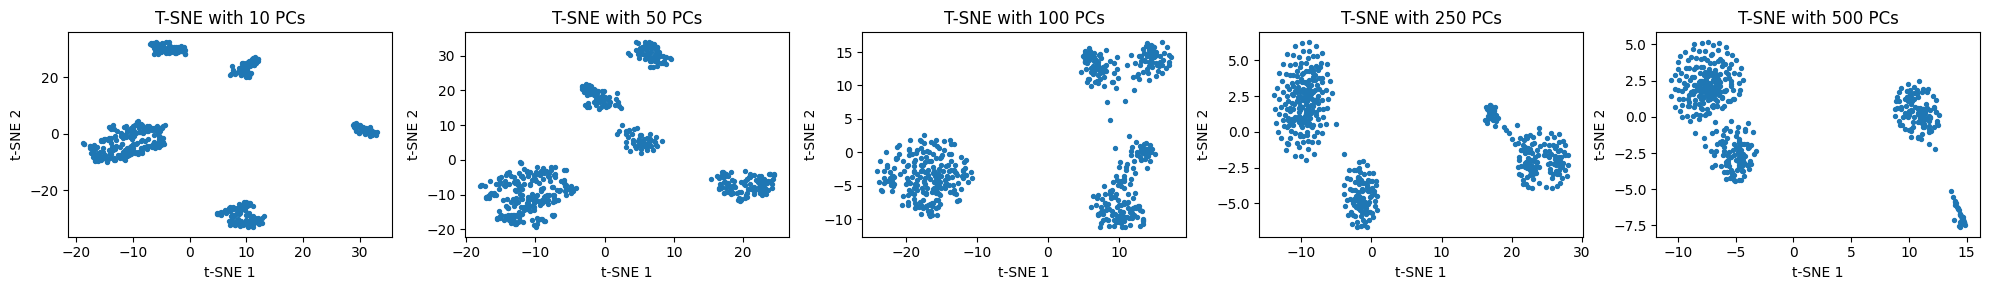

In [29]:
X = np.load('../../data/p1/X.npy')
X_log = np.log2(X+1)

pcs_list = [10, 50, 100, 250, 500]
fig, axes = plt.subplots(1, len(pcs_list), figsize=(20, 3))

for i, n_pcs in enumerate(pcs_list):
    pca = PCA(n_components=n_pcs, random_state=1)
    X_pca = pca.fit_transform(X_log)
    
    tsne = TSNE(n_components=2, perplexity=40, random_state=1)
    X_tsne = tsne.fit_transform(X_pca)
    
    axes[i].scatter(X_tsne[:,0], X_tsne[:,1], s=8)
    axes[i].set_title(f"T-SNE with {n_pcs} PCs")
    axes[i].set_xlabel("t-SNE 1")
    axes[i].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

T-SNE using different numbers of principal components, I noticed clear changes in the visualized clusters. With 10 PCs, I could see five groups, and with 50 PCs, the same five groups appeared but the data were slightly more dispersed. Using 100 PCs, the points formed three main groups with noticeable dispersion. With 250 PCs, the three groups remained, but the dispersion increased slightly. Finally, with 500 PCs, only two main clusters were visible, with a high level of dispersion. This shows that the choice of the number of PCs can strongly affect the apparent cluster structure in T-SNE.

  
>**2.** Pick three hyper-parameters below and analyze how changing the hyper-parameters affect the conclusions that can be drawn from the data. Please choose at least one hyper-parameter from each of the two categories (visualization and clustering/feature selection). At minimum, evaluate the hyper-parameters individually, but you may also evaluate how joint changes in the hyper-parameters affect the results. You may use any of the datasets we have given you in this project. For visualization hyper-parameters, you may find it productive to augment your analysis with experiments on synthetic data, though we request that you use real data in at least one demonstration.
Some possible choices of hyper-parameters are:

> **Category A (visualization):**
>- T-SNE perplexity
>- T-SNE learning rate
>- T-SNE early exaggeration
>- T-SNE initialization
>- T-SNE number of iterations/convergence tolerance

> **Category B (clustering/feature selection):**
>- Effect of number of PC's chosen on clustering
>- Type of clustering criterion used in hierarchical clustering (single linkage vs ward, for example)
>- Number of clusters chosen for use in unsupervised feature selection and how it affects the quality of the chosen features
>- Magnitude of regularization and its relation to your feature selection (for example, does under or over-regularizing the model lead to bad features being selected?)
>- Type of regularization ($L^1$, $L^1$, elastic net) in the logistic regression step and how the resulting features selected differ

> For visualization hyper-parameters, provide substantial visualizations and explanation on how the parameter affects the image.

> For clustering/feature selection, provide visualizations and/or numerical results which demonstrate how different choices affect the downstream visualizations and feature selection quality.

> Provide adequate explanations in words for each of these visualizations and numerical results.  


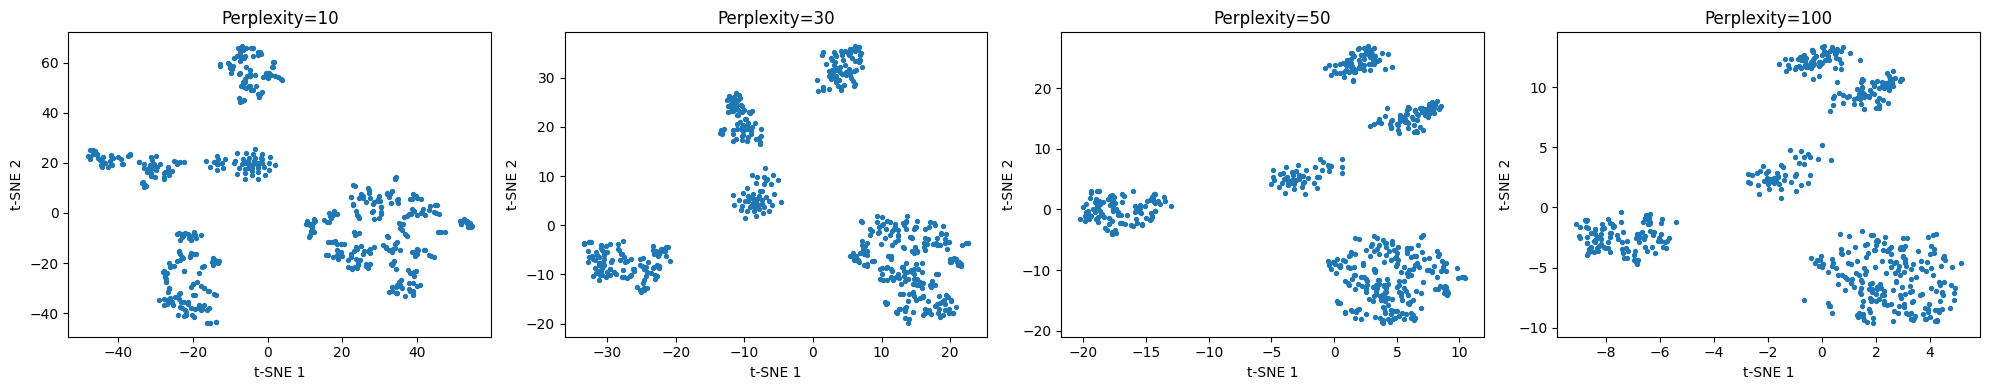

In [ ]:
# T-SNE perplexity

perplexities = [10, 30, 50, 100]
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for i, p in enumerate(perplexities):
    pca = PCA(n_components=50, random_state=1)
    X_pca = pca.fit_transform(X_log)
    tsne = TSNE(n_components=2, perplexity=p, random_state=1)
    X_tsne = tsne.fit_transform(X_pca)
    
    axes[i].scatter(X_tsne[:,0], X_tsne[:,1], s=8)
    axes[i].set_title(f"Perplexity={p}")
    axes[i].set_xlabel("t-SNE 1")
    axes[i].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

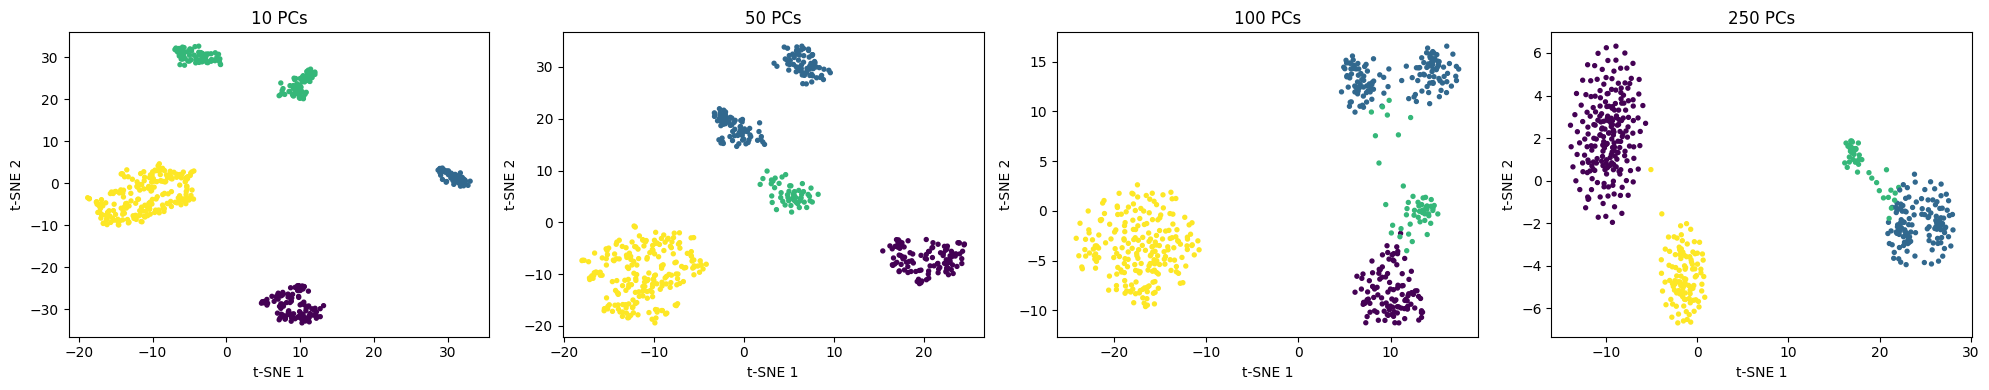

In [36]:
# PCs for K-Means
pcs_list = [10, 50, 100, 250]
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for i, n_pc in enumerate(pcs_list):
    pca = PCA(n_components=n_pc, random_state=1)
    X_pca = pca.fit_transform(X_log)
    
    # Clustering
    kmeans = KMeans(n_clusters=4, random_state=1)
    clusters = kmeans.fit_predict(X_pca)
    
    # T-SNE para visualización
    tsne = TSNE(n_components=2, perplexity=40, random_state=1)
    X_tsne = tsne.fit_transform(X_pca)
    
    axes[i].scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, cmap="viridis", s=8)
    axes[i].set_title(f"{n_pc} PCs")
    axes[i].set_xlabel("t-SNE 1")
    axes[i].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

In [35]:
# Regularization in Logistic Regression
X_pca50 = PCA(n_components=50, random_state=1).fit_transform(X_log)
clusters = KMeans(n_clusters=4, random_state=1).fit_predict(X_pca50)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

C_values = [0.01, 0.1, 1, 10]
for C in C_values:
    lr = LogisticRegression(penalty='l2', C=C, max_iter=1000, random_state=1)
    lr.fit(X_scaled, clusters)
    coef_sum = np.sum(np.abs(lr.coef_))
    print(f"C={C}, sum of absolute coefficients: {coef_sum:.2f}")

C=0.01, sum of absolute coefficients: 57.13
C=0.1, sum of absolute coefficients: 73.94
C=1, sum of absolute coefficients: 235.61
C=10, sum of absolute coefficients: 235.97


First, I ran T-SNE with perplexities of 10, 30, 50, and 100. I observed that low perplexities (10–30) produced more fragmented clusters, highlighting local structure, while higher perplexities (50–100) resulted in smoother embeddings where some clusters appeared to merge. This demonstrates that the perceived separation of cell groups can vary depending on the perplexity choice.

Second, I varied the number of principal components used for K-Means clustering (10, 50, 100, 250). With few PCs, clusters were more fragmented, and feature selection tended to pick noisy genes. Increasing the number of PCs stabilized the clustering and allowed the identification. Beyond around 50 PCs, adding more components only introduced minor variations without substantial improvement.





Finally, In the regularization parameter C affects feature selection in multinomial logistic regression. Using the cluster assignments as pseudo-labels, The sum of the absolute values of the coefficients for different values of C. With strong regularization (C=0.01), the total coefficient sum was 57.13, meaning only a few genes had substantial influence. Increasing C to 0.1 raised the sum to 73.94, and further to 235.61 at C=1. Beyond that, at C=10, the sum barely changed (235.97), showing a plateau. This indicates that small C values focus on a few highly informative genes, while larger C values allow more genes to contribute, including smaller-effect ones. Overall, the results suggest that most important genes are captured around C=1, and using too small or too large a C could either miss informative genes or include noise.